In [5]:
try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle
    
from smr import File
import numpy as np
from matplotlib import pyplot as plt


In [6]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
f_name = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/2006/Pip/P21/P21_1 LBW5 RFW5 B.smr'

In [198]:
smr_content = File(f_name)
smr_content.read_channels()

Not implemented (type = 5)


In [201]:
# for chan in smr_content.channels:
#     print(chan)

# # print(smr_content.__dict__)
# print(vt.__dict__)

# dti = (vt.last_block - vt.first_block)/float(vt.data.size)
# idx = (int((vt.blocks[1]-vt.first_block)*dti))

chan_titles = [chan.title for chan in smr_content.channels]
for i, ct in enumerate(chan_titles):
    print("{}: {}".format(i, ct))

0: Unit
1: HEpos
2: VEpos
3: HTpos
4: VTpos
5: Keyboard


<IPython.core.display.Javascript object>


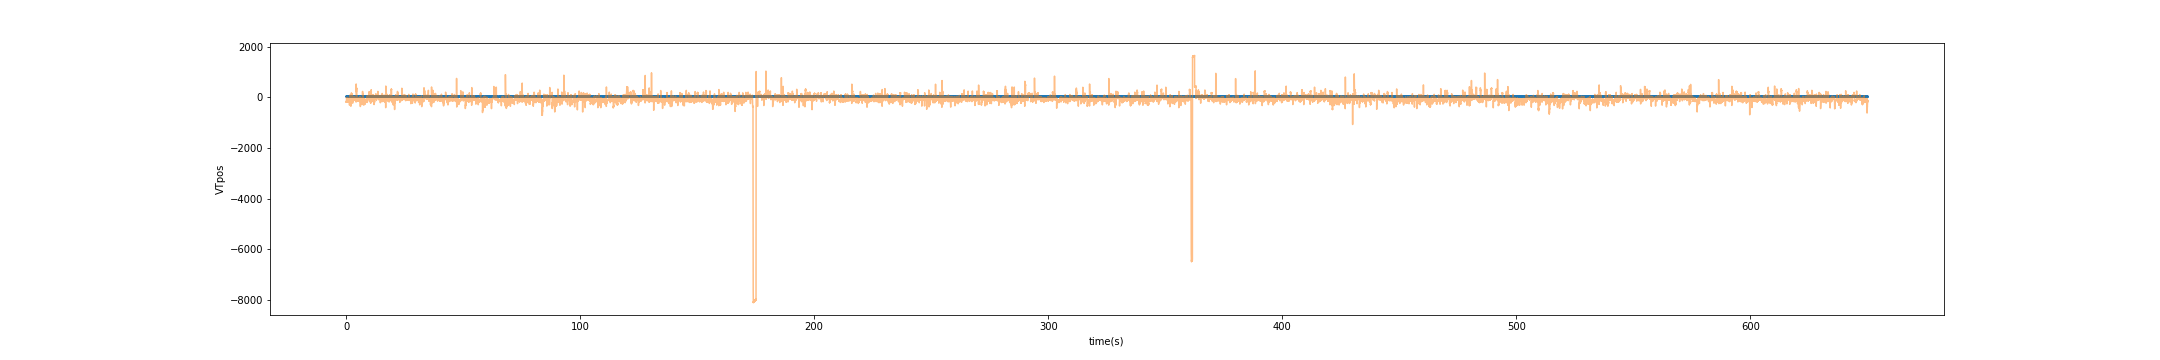

<IPython.core.display.Javascript object>


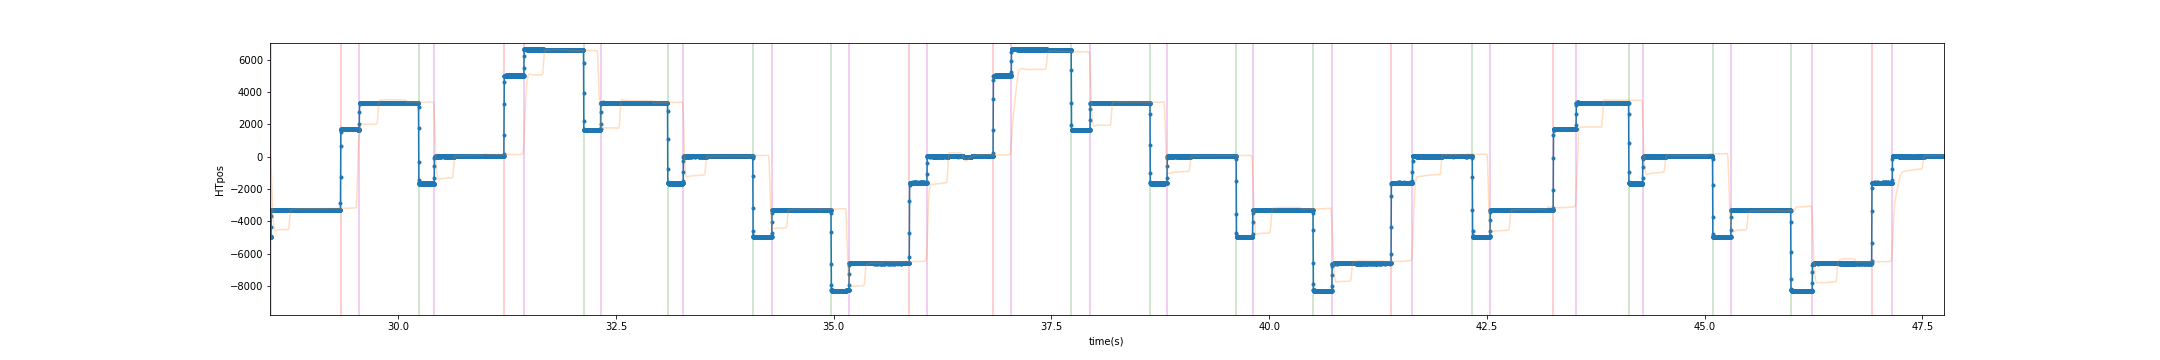

In [217]:
%matplotlib notebook
import scipy.signal

# import time
#time.sleep(5)  

#Params:
t_range = (0,700) #s
fsize = (30,5)


vt = smr_content.get_channel(4)
ve = smr_content.get_channel(2)

ht = smr_content.get_channel(3)
he = smr_content.get_channel(1)

i_range = [int(x/vt.dt) for x in t_range]
prange = slice(i_range[0], i_range[1])

plt.figure(figsize = fsize)
# plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange]/float(2*vt.divide))
# plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, ve.data[prange]/float(2*ve.divide), alpha=0.5)
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange])
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, ve.data[prange], alpha=0.5)
plt.ylabel(vt.title)
plt.xlabel('time(s)')

plt.figure(figsize = fsize)
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange]/float(2*ht.divide),'.-')
# plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange]/float(2*ht.divide), alpha=0.25)

plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange],'.-')
plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, he.data[prange], alpha=0.25)

plt.ylabel(ht.title)
plt.xlabel('time(s)')


# find target jumps
ht_diff = np.abs(np.diff(ht.data[prange]))
target_jump_indices = scipy.signal.find_peaks(ht_diff, prominence=200)[0]

# remove detected target jumps that are sequential (less than 5 samples apart)
to_delete = []
for i, tji in enumerate(target_jump_indices[1:]):
    if tji - target_jump_indices[i] < 5:
        to_delete = to_delete + [i+1]
mask = np.ones(target_jump_indices.shape, dtype=bool)
mask[to_delete] = False
target_jump_indices = target_jump_indices[mask]

# plt.plot(peaks*ht.dt, ht.data[prange][peaks], '*r')

from kaveh import plots
# plots.axvlines(plt.gca(), target_jump_indices*ht.dt, alpha = 0.25, color='red')
# plots.axvlines(plt.gca(), 66188*ht.dt, alpha = 0.75, color='g')
# plots.axvlines(plt.gca(), (tji+5)*ht.dt, alpha = 0.75, color='b')
# plots.axvlines(plt.gca(), (tji-5)*ht.dt, alpha = 0.75, color='b')

# plt.figure()
# for i in range(1000):
#     plt.plot(ht.data[prange],vt.data[prange], '.')
#     plt.xlabel(ht.title[i])
#     plt.ylabel(vt.title[i])
#     time.sleep(0.01)
#     plt.cla()

In [218]:
# histogram of target jumps

jump_vecs = []
for tji in target_jump_indices:
    jump_vecs = jump_vecs + [ht.data[prange][tji + 5] - ht.data[prange][tji - 5]]
#     if ht.data[prange][tji + 5] - ht.data[prange][tji - 5] < 8400 and ht.data[prange][tji + 5] - ht.data[prange][tji - 5] > 8200:
#         print(tji)
#         print(ht.data[prange][tji + 5])
#         print(ht.data[prange][tji - 5])


bin_size = 200
# plt.figure()
# plt.hist(jump_vecs, bins=np.arange(-10000, 10000, bin_size))
[hist, bin_edges] = np.histogram(jump_vecs, bins=np.arange(-10000, 10000, bin_size))
hist[hist < 20] = 0 # remove rare target jump vectors
jump_amps = bin_edges[np.nonzero(hist)]
print(jump_amps)

primary_to_left = []
primary_to_right = []
corrective_to_right = []
for tji in target_jump_indices:
    jump_vec = ht.data[prange][tji + 5] - ht.data[prange][tji - 5]
    if jump_vec < jump_amps[0] + bin_size and jump_vec > jump_amps[0]:
        primary_to_left = primary_to_left + [tji]
    elif jump_vec < jump_amps[1] + bin_size and jump_vec > jump_amps[1]:
        corrective_to_right = corrective_to_right + [tji]
    elif jump_vec < jump_amps[2] + bin_size and jump_vec > jump_amps[2]:
        primary_to_right = primary_to_right + [tji]

primary_to_left = np.array(primary_to_left)  
primary_to_right = np.array(primary_to_right)
corrective_to_right = np.array(corrective_to_right)

plots.axvlines(plt.gca(), primary_to_right*ht.dt, alpha = 0.25, color='red')        
plots.axvlines(plt.gca(), primary_to_left*ht.dt, alpha = 0.25, color='g')     
plots.axvlines(plt.gca(), corrective_to_right*ht.dt, alpha = 0.25, color='m')     

[-5000  1600  4800]


<IPython.core.display.Javascript object>


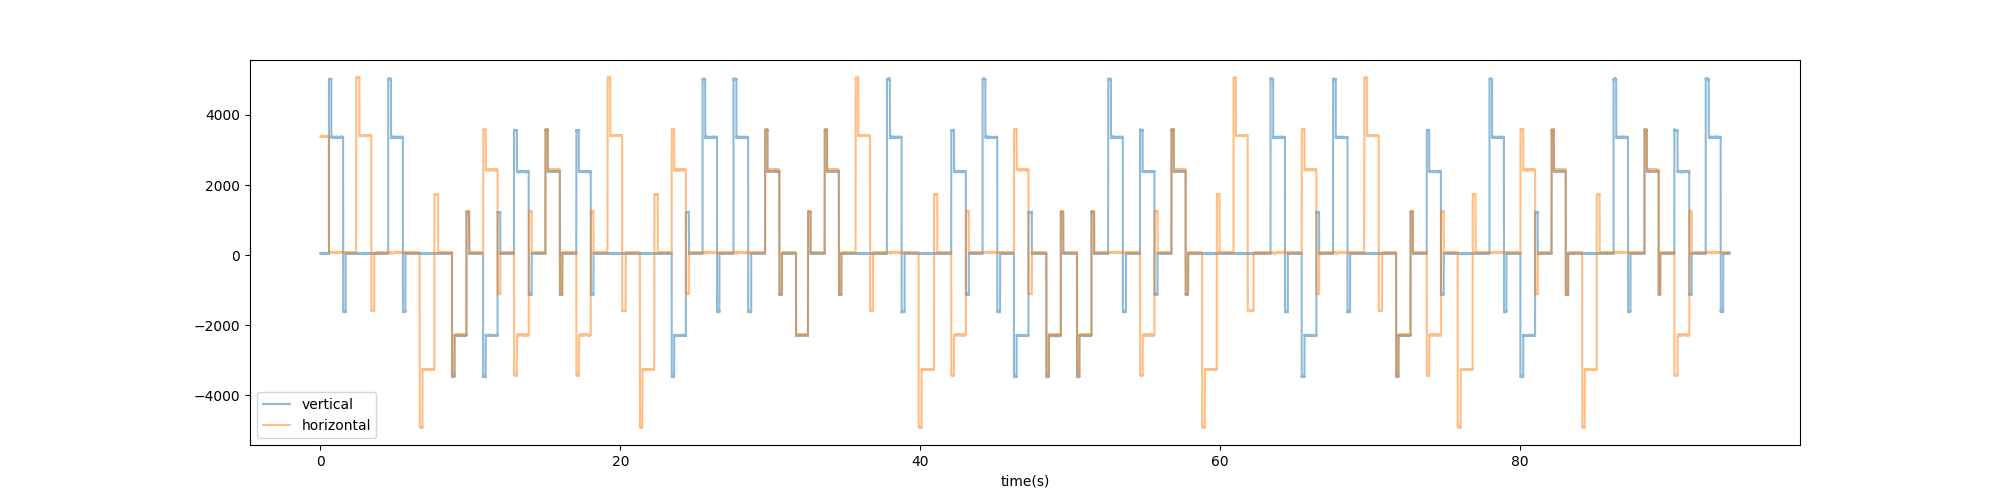

In [11]:
t_range = (6,100) #s
fsize = (20,5)


vt = smr_content.get_channel(4)

i_range = [int(x/vt.dt) for x in t_range]
prange = slice(i_range[0], i_range[1])

plt.figure(figsize = fsize)
plt.plot(np.arange(0, vt.data[prange].size)*vt.dt, vt.data[prange], alpha=0.5)
plt.xlabel('time(s)')
ht = smr_content.get_channel(3)
plt.plot(np.arange(0, ht.data[prange].size)*ht.dt, ht.data[prange] , alpha=0.5)
plt.legend(['vertical', 'horizontal'])


KeyboardInterrupt: 

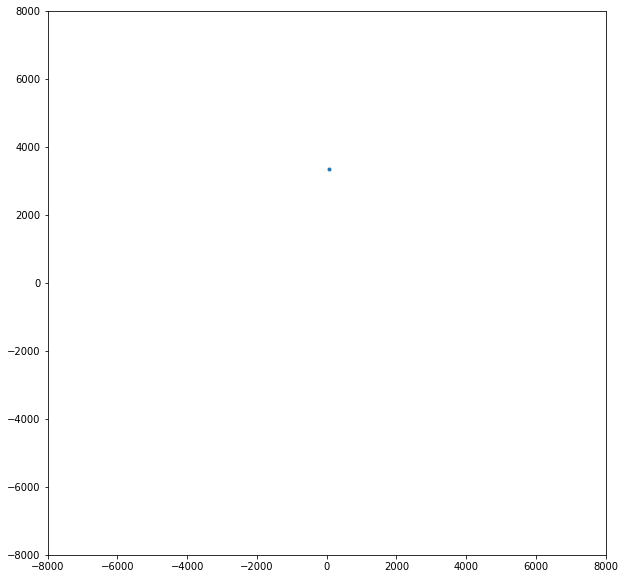

In [15]:
%matplotlib inline
import time
# import pylab as pl
from IPython import display
plt.figure(figsize=(10,10))

for i in range(i_range[0], i_range[1], 5):
    plt.plot(ht.data[i],vt.data[i], '.')
    plt.ylim((-8000,8000))
    plt.xlim((-8000,8000))
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.005)
    plt.cla()
#     plt.cla()

In [ ]:
plt.figure(figsize=fsize)
ht_diff = np.abs(np.diff(ht.data[prange]))
plt.plot(np.arange(0, ht_diff.size)*ht.dt, ht_diff)
plt.ylabel("diff of {}".format(ht.title))
plt.xlabel('time(s)')

import scipy.signal

peaks = scipy.signal.find_peaks(ht_diff, prominence=100)[0]-1

plt.plot(peaks*ht.dt, ht_diff[peaks], '*r')
# plt.figure(figsize=fsize)
# plt.plot(scipy.signal.find_peaks(ht_diff)[1])

In [ ]:
# import csv
# import os

# def append_to_csv_string(csv_string, new_string):
#     if not csv_string:
#         return new_string
#     else:
#         return [csv_string] + [new_string]


# source_path = '/mnt/papers/Herzfeld_Nat_Neurosci_2018/raw_data/'

# with open('behavioral_index.csv', 'a') as f:
#     for root, dirnames, filenames in os.walk(source_path):
#         for filename in filenames:
#             if filename.endswith('smr'):
#                 f_name = os.path.join(root, filename)
#                 csv_row = [f_name];
                
#                 smr_content = File(f_name)
#                 smr_content.read_channels()
                
#                 chans = smr_content.channels
                
#                 for i, chan in enumerate(chans):
#                     if 'VT' in chan.title:
#                         csv_row = csv_row + ['VT'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['VT'] + ['NA']

#                     if 'HT' in chan.title:
#                         csv_row = csv_row + ['HT'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['HT'] + ['NA']

#                     if 'VE' in chan.title:
#                         csv_row = csv_row + ['VE'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['VE'] + ['NA']

#                     if 'HE' in chan.title:
#                         csv_row = csv_row + ['HE'] + [i]
# #                     else:
# #                         csv_row = csv_row + ['HE'] + ['NA']

#                 print(csv_row)
#                 writer = csv.writer(f)
#                 writer.writerow(csv_row)

                        
                    
                    
            